# Descrição do Trabalho



- Neste trabalho, realizaremos a tarefa de análise de sentimentos. Dado um texto, faremos a classificação binária determinando se o sentimento é positivo ou negativo.

- Para este fim, utilizaremos o conjunto de dados "No Theme Tweets": dados coletados baseando nos emoticons positivos e negativos,e tem aproximadamente 780k tweets, mas pegamos apenas 40k de tweets.

- O objetivo deste trabalho é utilizar embeddings previamente extraídos por um modelo de linguagem, que converte o texto em representações numéricas no espaço latente, e a partir deles construir um classificador supervisionado que realize a predição do sentimento e justifique a implementação mostrando os resultados obtidos na última Seção.

#### **Detalhes**:
- Grupo de no máximo 3 pessoas
- A partir dessas informações, faça um loop de treinamento que realize essa tarefa
- Grave um vídeo de até 10 minutos por grupo explicando suas decisões.




# Preparando os dados (Utilize o tweet_embeddings.pkl já convertido na seçao abaixo)


In [1]:
"""
import pandas as pd
import torch

df = pd.read_csv('NoThemeTweets.csv', encoding='utf-8')
df = df[['tweet_text', 'sentiment']]
df['sentiment'] = df['sentiment'].map({'Negativo': 0, 'Positivo': 1})

df_pos = df[df['sentiment'] == 1].sample(n=20000, random_state=42)
df_neg = df[df['sentiment'] == 0].sample(n=20000, random_state=42)
df = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=42).reset_index(drop=True)

df.head(100)
"""

"\nimport pandas as pd\nimport torch\n\ndf = pd.read_csv('NoThemeTweets.csv', encoding='utf-8')\ndf = df[['tweet_text', 'sentiment']]\ndf['sentiment'] = df['sentiment'].map({'Negativo': 0, 'Positivo': 1})\n\ndf_pos = df[df['sentiment'] == 1].sample(n=20000, random_state=42)\ndf_neg = df[df['sentiment'] == 0].sample(n=20000, random_state=42)\ndf = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=42).reset_index(drop=True)\n\ndf.head(100)\n"

In [2]:
"""
from transformers import BertTokenizer, BertModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = model.to(device)
model.eval()
"""

"\nfrom transformers import BertTokenizer, BertModel\n\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\n\ntokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')\nmodel = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')\nmodel = model.to(device)\nmodel.eval()\n"

In [3]:
"""
import torch
from tqdm import tqdm

sentences = df['tweet_text'].astype(str).tolist()
embeddings = []

batch_size = 32

with torch.no_grad():
    for i in tqdm(range(0, len(sentences), batch_size)):
        batch = sentences[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='pt', truncation=True,
                          padding=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.extend(cls_embeddings)

df['embedding'] = embeddings
"""

"\nimport torch\nfrom tqdm import tqdm\n\nsentences = df['tweet_text'].astype(str).tolist()\nembeddings = []\n\nbatch_size = 32\n\nwith torch.no_grad():\n    for i in tqdm(range(0, len(sentences), batch_size)):\n        batch = sentences[i:i+batch_size]\n        inputs = tokenizer(batch, return_tensors='pt', truncation=True,\n                          padding=True, max_length=128)\n        inputs = {k: v.to(device) for k, v in inputs.items()}\n        outputs = model(**inputs)\n        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()\n        embeddings.extend(cls_embeddings)\n\ndf['embedding'] = embeddings\n"

In [4]:
"""
from google.colab import files
df.to_pickle('tweet_embeddings.pkl')
files.download('tweet_embeddings.pkl')
"""

"\nfrom google.colab import files\ndf.to_pickle('tweet_embeddings.pkl')\nfiles.download('tweet_embeddings.pkl')\n"

# Treinando um modelo que classifica os textos

In [5]:

"""
==========================================================================
                        Carregando o Arquivo
==========================================================================
"""
!pip install -q gdown

!gdown 1RfpOG0xOyulZdZonn21MKFbsk0VbATZ1


Downloading...
From (original): https://drive.google.com/uc?id=1RfpOG0xOyulZdZonn21MKFbsk0VbATZ1
From (redirected): https://drive.google.com/uc?id=1RfpOG0xOyulZdZonn21MKFbsk0VbATZ1&confirm=t&uuid=f942f13e-73f9-4aba-ba04-d01144d18f84
To: /home/jovyan/tweet_embeddings.pkl
100%|████████████████████████████████████████| 128M/128M [00:02<00:00, 49.3MB/s]


In [6]:

"""
==========================================================================
                        Loop de treinamento
==========================================================================
"""

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import os # Import para lidar com caminhos do sistema
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- CONFIGURAÇÃO DE CAMINHOS DINÂMICOS ---
# Testei isso no servidor de casa prof
BASE_DIR = os.getcwd()
DATA_PATH = os.path.join(BASE_DIR, 'tweet_embeddings.pkl')
MODEL_PATH = os.path.join(BASE_DIR, 'melhor_modelo.pth')

print(f"Diretório de trabalho: {BASE_DIR}")
print(f"Caminho dos dados: {DATA_PATH}")

# Verificação de segurança
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"O arquivo '{DATA_PATH}' não foi encontrado.")

df = pd.read_pickle(DATA_PATH)

X = np.array(df['embedding'].tolist())
y = df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

Diretório de trabalho: /home/jovyan
Caminho dos dados: /home/jovyan/tweet_embeddings.pkl


In [7]:
df.head(10)


,tweet_text,sentiment,embedding
0,"@anaxxbor Tudo bem, eu entendo, tmb queria pod...",0,"[0.10315908, 0.013129968, 0.34306428, -0.06282..."
1,@BamBam1A a bop :),1,"[-0.034320716, -0.109774746, 0.3471264, -0.265..."
2,@adeliodavid19 Oh adelio nao sejas mau :(,0,"[0.2308408, -0.20745486, -0.028029501, 0.17373..."
3,Estive uma hora à espera do autocarro e agora ...,1,"[0.05930154, -0.10265243, 0.4114879, 0.0703987..."
4,@gichavesoficial ainda estou triste porque voc...,0,"[0.20376101, 0.006046499, 0.08276472, -0.22038..."
5,porra yuu e nanami vcs se amam parem de machuc...,0,"[-0.004406034, 0.24167478, 0.24885137, -0.2370..."
6,@ProfessAstromar também não tenho :) é defeito?,1,"[0.1009029, -0.04155081, 0.37784517, -0.041520..."
7,@Faelos03 @palassi_f EU SEI ARRUMAR CABELO :(,0,"[0.42391905, 0.12118148, 0.1165956, 0.09888145..."
8,"nada de falar de política, só um pastel e um p...",1,"[-0.18412839, 0.032775246, 0.25164554, 0.00398..."
9,Apoiadores de outros candidatos taxando os ele...,0,"[-0.27203593, 0.36342573, -0.09187827, -0.3874..."


In [ ]:
"""
==========================================================================
                        Modelo Otimizado
==========================================================================
"""
class TextClassifier(nn.Module):
    def __init__(self, input_dim=768, num_classes=2):
        super().__init__()
        
        # Na nossa arquitetura preferimos utilizar uma abordagem de redução gradual (funil) para evitar overfitting. e melhorar a generalização.
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 256), # redução inicial
            nn.BatchNorm1d(256), # Normalização para estabilizar o aprendizado
            nn.GELU(), # Ativação GELU para melhorar a performance em NLP
            nn.Dropout(0.3) # Dropout moderado para evitar overfitting
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Dropout(0.2) # Dropout menor pois a camada é menor
        )
        
        # Camada de Saída
        self.fc_out = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.fc_out(x)
        return x

model = TextClassifier().to(device)

"""
==========================================================================
                        Loop de Treinamento
==========================================================================
"""
# Label Smoothing: para evitar overfitting penalizando certezas extremas (100%)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Weight Decay um pouco menor para acelerar a convergência
# Utilizamos AdamW ao invez de SGD pois ele é mais eficiente para problemas de NLP
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Scheduler para reduzir a taxa de aprendizado quando o modelo parar de melhorar
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)

#Epocas e tamanho do batch
epochs = 100 
batch_size = 64

# Configuração do Early Stopping
patience = 10           # Quantas épocas esperar sem melhora
patience_counter = 0    # Contador atual
best_test_loss = float('inf') # Melhor loss encontrado até agora
best_train_loss = float('inf') # Melhor loss de treino encontrado até agora
best_accuracy = 0.0 # Melhor acurácia encontrada

model.eval()
sample = X_train[0:1]
output = model(sample)
print(f"Input shape: {sample.shape}")
print(f"Output shape: {output.shape}")
print(f"Output (logits): {output}")
print(f"Predict: {output.argmax(dim=1).item()}")


# Codigo de treino
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Debug para verificar se a GPU está sendo usada
if torch.cuda.is_available():
    print(f"✅ GPU Detectada: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ GPU não detectada. O treinamento será lento na CPU.")


model = model.to(device)

# Dataloaders de iteração dos batches
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)    

train_loses_history = []
test_loses_history = []
accuracy_history = []


progress_bar = tqdm(range(epochs), desc="Training")

for epoch in progress_bar:
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device),labels.to(device)
        
        #Zera gradiente
        optimizer.zero_grad()
        
        #Passa dados pelo modelo
        outputs = model(inputs)
        
        #Calcula perda
        loss = criterion(outputs, labels)
        
        #Backpropagation e otimização
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    train_loses_history.append(avg_train_loss)
    
    model.eval()
    running_test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device),labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            running_test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_test_loss = running_test_loss/len(test_loader)
    acuracy = 100 * correct / total
    
    # Atualiza o learning rate baseado no erro de teste
    scheduler.step(avg_test_loss) 
    
    test_loses_history.append(avg_test_loss)
    accuracy_history.append(acuracy)

    progress_bar.set_postfix({
        'Train Loss': f'{avg_train_loss:.4f}',
        'Test Loss': f'{avg_test_loss:.4f}',
        'Accuracy': f'{acuracy:.2f}%'
    })

    # --- (EARLY STOPPING) ---
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_train_loss = avg_train_loss
        best_accuracy = acuracy
        patience_counter = 0
        # Salva o melhor modelo encontrado no caminho dinâmico
        torch.save(model.state_dict(), MODEL_PATH)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nParando o treino antecipadamente na época {epoch+1}!")
            break

# carregar melhor modelo e coloca-lo em modo de teste
print(f"🔄 Carregando o melhor modelo salvo de: {MODEL_PATH}")
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

model.eval() 

print(f"Modelo pronto para testes! Best train loss: {best_train_loss:.4f} | Best test loss: {best_test_loss:.4f} | Acuraccy: {best_accuracy:.2f}%")

/opt/conda/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Input shape: torch.Size([1, 768])
Output shape: torch.Size([1, 2])
Output (logits): tensor([[-0.1108,  0.0723]], device='cuda:0', grad_fn=<AddmmBackward0>)
Predict: 1
✅ GPU Detectada: NVIDIA GeForce GTX 1060 6GB


Training:  81%|████████  | 81/100 [02:48<00:39,  2.08s/it, Train Loss=0.2086, Test Loss=0.2406, Accuracy=97.90%]


Parando o treino antecipadamente na época 82!
🔄 Carregando o melhor modelo salvo de: /home/jovyan/melhor_modelo.pth
Modelo pronto para testes! Best train loss: 0.2089 | Best test loss: 0.2405 | Acuraccy: 97.91%


# Avaliação dos Experimentos (**Importante**)

#### Comente sobre o experimento, destaque os erros (se houver), apresente a matriz de confusão, report, análise de parâmetros…

Relatório de Classificação:

              precision    recall  f1-score   support

    Negativo       0.98      0.98      0.98      4003
    Positivo       0.98      0.98      0.98      3997

    accuracy                           0.98      8000
   macro avg       0.98      0.98      0.98      8000
weighted avg       0.98      0.98      0.98      8000



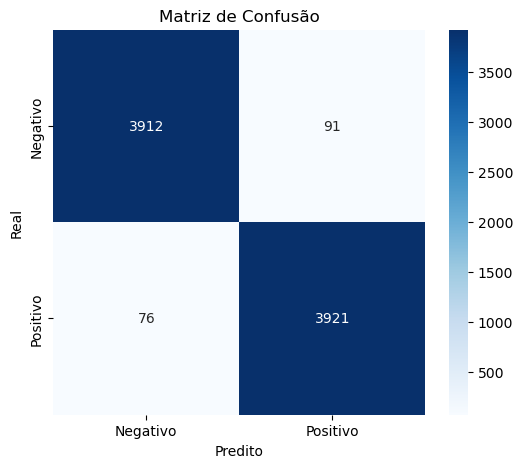

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Colocar o modelo em modo de avaliação
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 1. Relatório de Classificação
print("Relatório de Classificação:\n")
print(classification_report(y_true, y_pred, target_names=['Negativo', 'Positivo']))

# 2. Matriz de Confusão Visual
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

## Commentar
"Os resultados foram excelentes, provavelmente porque o dataset original foi rotulado com base em emoticons. O modelo BERT conseguiu capturar essa característica forte (ou palavras muito associadas a felicidade)

In [10]:
"""
==========================================================================
            Teste com Novos Dados (Nunca vistos pelo modelo)
==========================================================================
"""
!pip install -q kagglehub

import kagglehub
import pandas as pd
import torch
import numpy as np
import os
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
from IPython.display import display

# --- CONFIGURAÇÃO DO TESTE ---
# Altere estes parâmetros conforme necessário. 
# O script detectará mudanças e reprocessará os dados automaticamente.
TEST_CONFIG = {
    'SAMPLE_SIZE': 1000,        # Quantidade de amostras de cada classe (Pos/Neg)
    'RANDOM_STATE_UNUSED': 99,  # Seed para seleção dos dados inéditos
    'BATCH_SIZE': 32            # Tamanho do batch para o BERT
}
CACHE_FILE = 'new_test_data_cache.pkl' 

# Lógica de Cache Dinâmico
need_process = True
if os.path.exists(CACHE_FILE):
    try:
        cache_content = pd.read_pickle(CACHE_FILE)
        # Verifica se o cache tem a estrutura esperada e se a config é a mesma
        if isinstance(cache_content, dict) and cache_content.get('config') == TEST_CONFIG:
            print(f"♻️ Configuração idêntica detectada. Carregando dados do cache '{CACHE_FILE}'...")
            df_new_test = cache_content['df']
            new_embeddings = np.array(df_new_test['embedding'].tolist())
            need_process = False
        else:
            print("⚠️ Configuração alterada. Os dados serão reprocessados...")
    except Exception as e:
        print(f"⚠️ Erro ao ler cache ({e}). Reprocessando...")

if need_process:
    print("⚙️ Iniciando processamento de novos dados...")
    
    # 1. Baixar e Carregar o Dataset Completo
    print("📥 Baixando dataset original via KaggleHub...")
    path = kagglehub.dataset_download("flaviagg/nothemetweets")
    
    df_full = pd.read_csv(path + "/NoThemeTweets.csv", encoding='utf-8')
    df_full = df_full[['tweet_text', 'sentiment']]
    df_full['sentiment'] = df_full['sentiment'].map({'Negativo': 0, 'Positivo': 1})

    # 2. Separar dados que NÃO foram usados no treino
    print("✂️ Separando dados inéditos...")
    df_pos_all = df_full[df_full['sentiment'] == 1]
    df_neg_all = df_full[df_full['sentiment'] == 0]

    # Recria índices usados no treino (Hardcoded seed=42, n=20000 conforme treino original)
    train_pos_indices = df_pos_all.sample(n=20000, random_state=42).index
    train_neg_indices = df_neg_all.sample(n=20000, random_state=42).index

    df_pos_unused = df_pos_all.drop(train_pos_indices)
    df_neg_unused = df_neg_all.drop(train_neg_indices)

    # Seleciona nova amostra baseada na config
    new_pos = df_pos_unused.sample(n=TEST_CONFIG['SAMPLE_SIZE'], random_state=TEST_CONFIG['RANDOM_STATE_UNUSED'])
    new_neg = df_neg_unused.sample(n=TEST_CONFIG['SAMPLE_SIZE'], random_state=TEST_CONFIG['RANDOM_STATE_UNUSED'])

    df_new_test = pd.concat([new_pos, new_neg]).sample(frac=1, random_state=TEST_CONFIG['RANDOM_STATE_UNUSED']).reset_index(drop=True)

    # 3. Gerar Embeddings
    print("🧠 Carregando BERT e gerando embeddings...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
    bert_model = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')
    bert_model = bert_model.to(device)
    bert_model.eval()

    sentences = df_new_test['tweet_text'].astype(str).tolist()
    embeddings_list = []
    batch_size = TEST_CONFIG['BATCH_SIZE']

    with torch.no_grad():
        for i in tqdm(range(0, len(sentences), batch_size), desc="Embedding"):
            batch = sentences[i:i+batch_size]
            inputs = tokenizer(batch, return_tensors='pt', truncation=True,
                              padding=True, max_length=128)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = bert_model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings_list.extend(cls_embeddings)
            
    # Salva no DataFrame e no Cache junto com a config
    df_new_test['embedding'] = list(embeddings_list)
    new_embeddings = np.array(embeddings_list)
    
    cache_data = {'df': df_new_test, 'config': TEST_CONFIG}
    pd.to_pickle(cache_data, CACHE_FILE)
    print(f"💾 Dados processados e salvos em '{CACHE_FILE}'.")

# 4. Avaliação com o Modelo Treinado
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if 'model' not in globals():
    print("⚠️ Modelo classificador não encontrado na memória. Execute as células de treinamento antes.")
else:
    print("\n🧪 Executando predições com o modelo treinado...")
    X_new = torch.tensor(new_embeddings, dtype=torch.float32).to(device)
    y_new_true = torch.tensor(df_new_test['sentiment'].values, dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(X_new)
        _, predictions = torch.max(outputs, 1)

    # 5. Exibir Resultados
    correct = (predictions == y_new_true).sum().item()
    total = y_new_true.size(0)
    accuracy = 100 * correct / total

    print(f"\n✅ Taxa de Acerto Total (Acurácia) nos novos dados: {accuracy:.2f}%")

    # Criar tabela de visualização
    results_df = df_new_test.copy()
    results_df['Esperado'] = results_df['sentiment'].map({0: 'Negativo', 1: 'Positivo'})
    results_df['Resultado Final'] = predictions.cpu().numpy()
    results_df['Resultado Final'] = results_df['Resultado Final'].map({0: 'Negativo', 1: 'Positivo'})

    print("\n=== Tabela de Resultados (Amostra) ===")
    display(results_df[['tweet_text', 'Esperado', 'Resultado Final']].head(20))

2025-11-29 15:40:11.454239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764430811.645942  291715 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764430811.700775  291715 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-29 15:40:12.155417: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


♻️ Configuração idêntica detectada. Carregando dados do cache 'new_test_data_cache.pkl'...

🧪 Executando predições com o modelo treinado...

✅ Taxa de Acerto Total (Acurácia) nos novos dados: 97.65%

=== Tabela de Resultados (Amostra) ===


,tweet_text,Esperado,Resultado Final
0,@yoongibaep nao vai att mais bebe? :(,Negativo,Negativo
1,to no tédio :( fav aqui pra eu chamar na dm,Negativo,Negativo
2,Bonito ombligo de semana! :) https://t.co/h1z4...,Positivo,Positivo
3,eu odeio muito esse tweet pq agora toda vez q ...,Negativo,Negativo
4,"Sulphur Beach, Auckland . Tudo sobre a Nova Ze...",Positivo,Positivo
5,@bIushyty :) so precious aha,Positivo,Positivo
6,@bibi_zenati Nossa amor :(,Negativo,Negativo
7,Eu difamei alguém? Bruh eu sou o gajo mais chi...,Positivo,Positivo
8,Vi minha namorada hoje :) perfeita sem erros,Positivo,Positivo
9,meu gatinho louis ainda não voltou pra casa :((,Negativo,Negativo
